In [1]:
import os
os.chdir('/workspace')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch
from dataset.dataset_iter import data_formatting
warnings.filterwarnings('ignore')
from tqdm import tqdm

device="cuda"
d_type=torch.float32

In [2]:
import os

# 현재 위치
os.getcwd()

'/workspace'

# Modeling

In [3]:
def Mamba2Model():
    from model.mamba_stock import Mambamodeling
    pretrained_path="/workspace/weight/Mamba2"
    model=Mambamodeling(
            d_model=768,
            d_inermediate=2048,
            n_layer=8,
            layer="Mamba2",
            pretrained_path=pretrained_path
        ).to(device)
    model.eval()
    return model


def Mamba1Model():
    from model.mamba_stock import Mambamodeling
    pretrained_path="/workspace/weight/Mamba1"
    model=Mambamodeling(
            d_model=768,
            d_inermediate=2048,
            n_layer=8,
            layer="Mamba1",
            pretrained_path=pretrained_path
        ).to(device)
    model.eval()
    return model

def TransformerModel():
    from model.qwen_stock import QwenStock
    from transformers import AutoConfig
    
    model_name = "Qwen/Qwen2.5-Coder-0.5B-Instruct"
    
    qwenconfig=AutoConfig.from_pretrained(model_name,
                    intermediate_size= 2048,
                    max_position_embeddings= 128,
                    num_hidden_layers=8,
                    vocab_size= 5
                    )

    model=QwenStock(qwenconfig).from_pretrained("/workspace/weight/QWEN").to(device)
    return model


def xLSTM():
    from model.xlstm_stock import xLSTMStockModeling
    model=xLSTMStockModeling(pretrained_path="/workspace/weight/xLSTM2").to("cuda")
    
    return model
    

def predict(data,model,seq_length):
    stock_predictions=[]
    total= len(data)-seq_length
    
    for start_idx in tqdm(range(total), desc="Prediction", ncols=80, ascii=True):
        open=data.loc[data.index[start_idx], "Open"]
        input=data_formatting(data,start_idx,1,seq_length,d_type)
        with torch.no_grad():
            pred=model(input)[0,-1,:]
        price_pred=pred[3]*open/100
        stock_predictions.append(price_pred)
        if start_idx%200==0:
            torch.cuda.empty_cache()
    stock_predictions=torch.stack(stock_predictions, dim=0).cpu().numpy()
    data["predict"]=np.concatenate((np.zeros(seq_length), stock_predictions))
    return data


# Prediction

In [ ]:
from backtesting.test import EURUSD,GOOG

data_path="/workspace/data/HBARUSDT_hour.csv"
stock=pd.read_csv(data_path)
#stock=EURUSD
#data_path="/workspace/data/BTCUSDT_15min.csv"
#df=pd.read_csv(data_path)
#filter_date = '2024-12-01'  # 원하는 날짜를 입력하세요
#stock = df[pd.to_datetime(df['date']) > pd.to_datetime(filter_date)]


#model=TransformerModel()
#model=Mamba1Model()
model=xLSTM()
predict(stock,model,127)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=768', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/slstm_HS768BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
Building extension module slstm_HS768BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS768BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


ninja: no work to do.


Prediction: 100%|###########################| 4873/4873 [00:54<00:00, 89.81it/s]


,Open,High,Low,Close,Volume,predict
2017-04-19 09:00:00,1.07160,1.07220,1.07083,1.07219,1413,0.000000
2017-04-19 10:00:00,1.07214,1.07296,1.07214,1.07260,1241,0.000000
2017-04-19 11:00:00,1.07256,1.07299,1.07170,1.07192,1025,0.000000
2017-04-19 12:00:00,1.07195,1.07280,1.07195,1.07202,1460,0.000000
2017-04-19 13:00:00,1.07200,1.07230,1.07045,1.07050,1554,0.000000
...,...,...,...,...,...,...
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203,1.231171
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325,1.234816
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824,1.223001
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065,1.225421


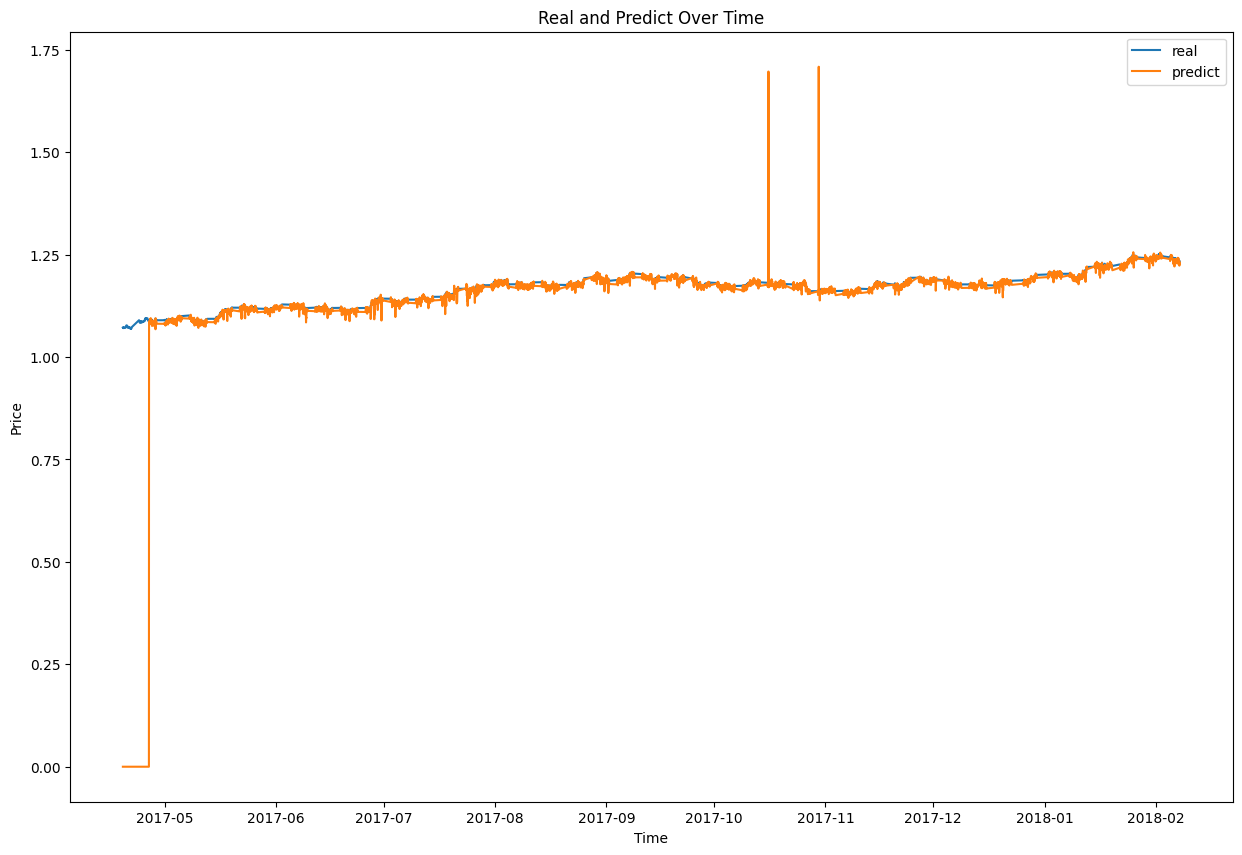

In [ ]:
# 데이터를 DataFrame으로 변환
time= pd.to_datetime(stock['open_time'], unit='ms')
stock["time"]=time
stock.set_index('time', inplace=True)
time=stock.index
# data2와 data1을 그래프로 그리기
plt.figure(figsize=(15, 10))  # 그래프 크기 설정 (선택적)
plt.plot(time, stock['Close'], label='real')
plt.plot(time, stock["predict"], label='predict')

# 그래프에 레이블과 범례 추가
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Real and Predict Over Time')
plt.legend()

# 그래프 표시
plt.show()

In [8]:
from backtesting import Strategy, Backtest
from backtesting.lib import SignalStrategy

class System(Strategy):
    def init(self):
        super().init()
        
    def next(self):
        price = self.data.Close[-1]         
        if (self.data.predict - price)/price > 0.001 and (self.data.predict - price)/price<0.2 and self.data.predict != 0:
            if not self.position.is_long:
                self.buy()      
        else:
            self.position.close()
       
            
backtest = Backtest(stock, System,
              cash=10000,
              commission=0.0002,
              exclusive_orders=True)


output=backtest.run()
#output.to_csv("/workspace/result/Mamba1_M.csv")
output

Start                     2017-04-19 09:00:00
End                       2018-02-07 15:00:00
Duration                    294 days 06:00:00
Exposure Time [%]                       28.86
Equity Final [$]                  8816.427527
Equity Peak [$]                  10000.842172
Return [%]                         -11.835725
Buy & Hold Return [%]               14.628937
Return (Ann.) [%]                   -11.87996
Volatility (Ann.) [%]                 2.37446
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.846708
Avg. Drawdown [%]                  -11.846708
Max. Drawdown Duration      286 days 14:00:00
Avg. Drawdown Duration      286 days 14:00:00
# Trades                                  585
Win Rate [%]                         39.65812
Best Trade [%]                       0.642989
Worst Trade [%]                     -0.791552
Avg. Trade [%]                    

In [7]:
from bokeh.plotting import figure, output_file, save

plot=backtest.plot()
save(plot)
plot

ValueError: failed to validate DatetimeTickFormatter(id='p1046', ...).days: expected a value of type str, got ['%d %b', '%a %d'] of type list